# Final Project: Defacing the Face
김소희 (서강대학교 국제한국학과)
- - - 

## Introduction
<img align="left" style="padding-right:15px;" src="facial_weaponization_suite.jpg" width="150">
This project is inspired by the Zach Blas's ＜Facial Weaponization Suite＞
With the development of technology, even when we are not aware, individual biometric facial data are being collected every minute in our daily lives. Such facial recognition technologies capture and calculate particular qualities from human faces, and categorize faces according to their races, genders, ages, religions, and even sexualities. This can intensify discrimination and inequality by marking minorities who are not incorporated into mainstream society with their facial data. 
<br><br>
The goal of this project is to make the masked face that cannot be detected by facial recognition technologies. First, the model is trained to classify faces based on the race and gender. Then the program detects user's face with a webcam, and idenfies her/his race and gender by using the trained model. Finally, the program defaces the user's face by overlaying the mask on the face, and lets the user to escape from facial recognition technologies.





## 1. Prerequisite
- Face datasets 
- haarcascade_frontalface_default.xml
- mask image file 

Download the all data from here https://drive.google.com/drive/folders/1V8GDEzi4xmEh2hZuew_Q_v7ddhCrGzFG?usp=sharing and locate it to the current directory. 


## 2. Transfer Learning

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2

plt.ion()   # interactive mode

### 2.1 Load Data

This model will classify faces based on the race and gender (Asian female, Asian male, Caucasian female, Caucasian male). I used [UTKFace dataset](https://susanqq.github.io/UTKFace/) as face datasets

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'transferlearning_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2.2 Visualize a few images

<class 'torch.Tensor'> tensor([1, 2, 2, 0])


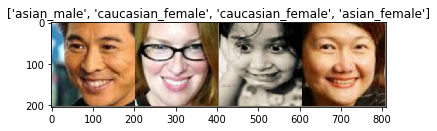

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(type(inputs), classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 2.3 Training the model

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    import copy
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
             
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
            
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
  
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 2.4 Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [17]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4) 

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized #lr:learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 2.5 Train and evaluate

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 1.2568 Acc: 0.4817
val Loss: 2.2268 Acc: 0.4067

Epoch 1/19
----------
train Loss: 0.9738 Acc: 0.6300
val Loss: 1.7483 Acc: 0.5017

Epoch 2/19
----------
train Loss: 0.6944 Acc: 0.7517
val Loss: 0.9000 Acc: 0.6500

Epoch 3/19
----------
train Loss: 0.6615 Acc: 0.7750
val Loss: 1.3779 Acc: 0.6017

Epoch 4/19
----------
train Loss: 0.7110 Acc: 0.7500
val Loss: 1.2131 Acc: 0.6350

Epoch 5/19
----------
train Loss: 0.5693 Acc: 0.7783
val Loss: 1.2167 Acc: 0.6300

Epoch 6/19
----------
train Loss: 0.3485 Acc: 0.8733
val Loss: 1.4402 Acc: 0.6033

Epoch 7/19
----------
train Loss: 0.3014 Acc: 0.8917
val Loss: 1.4179 Acc: 0.5667

Epoch 8/19
----------
train Loss: 0.2196 Acc: 0.9217
val Loss: 1.5294 Acc: 0.5867

Epoch 9/19
----------
train Loss: 0.1912 Acc: 0.9350
val Loss: 1.3777 Acc: 0.5883

Epoch 10/19
----------
train Loss: 0.2083 Acc: 0.9250
val Loss: 1.3587 Acc: 0.6117

Epoch 11/19
----------
train Loss: 0.2333 Acc: 0.9267
val Loss: 1.8674 Acc: 0.5183

Ep

## 3. Real Time Race & Gender Detection

In [29]:
# will use 'haarcascade' for face recognition
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

### 3.1 Save cropped face into the image file

In [30]:
def save_cropped_face(image): 
    # x = left, x+w = right, y = top, y+h = bottom 
    for (x,y,w,h) in faces:
        cropped_face = img[y:y+h, x:x+w]
        cv2.imwrite('cropped_face.jpg', cropped_face)

### 3.2 Detect the race and gender

`pil_loader()` loads the image file (cropped face) and `race_gender_detector()` identifies the race and gender of the image file by using the pre-trained model.

In [31]:
def pil_loader(path): #load the image file
    import PIL.Image
    with open(path, 'rb') as f:
        img = PIL.Image.open(f)
        return img.convert('RGB')

def race_gender_detector(img_src):
    img = pil_loader(img_src)

    timg = data_transforms['val'] (img) #normalize the data
    timg4 = timg.reshape(1, *timg.shape) #reshape the data to match the shape needed for the model
    timg4 = timg4.to(device)

    a = model_ft.to(device) (timg4) #run the model

    _, pred = torch.max(a,1)
    pred, pred.item()
    face_label = class_names[pred] #get the face label (race and gender)
    return face_label

### 3.3 Display the race and gender

In [32]:
def race_gender_tagger(img):
    for (x, y, w, h) in faces: 
        # draw rectangle around the face
        cv2.rectangle(img, (x, y), (x+w, y+h +20), (0, 0, 255), 2)
        cv2.rectangle(img, (x, y+h - 15), (x+w, y+h+20), (0, 0, 255), cv2.FILLED)
        # display gender and race of the face
        font = cv2.FONT_HERSHEY_TRIPLEX
        label = race_gender_detector('cropped_face.jpg')
        cv2.putText(img, label, (x + 6, y+h + 12), font, 0.7, (255, 255, 255), 1)    

### 3.4 Stream real-time video

This part streams the real-time video using the webcam and detects your face. Then your race and gender comes up on th frame. This is analogous to the situation that you are detected and categorized by the facial recognition technology in everyday life. 

In [40]:
cap = cv2.VideoCapture(0)
cap.set(3,640) # set Width
cap.set(4,480) # set Height

while True:
    #capture frame-by-frame
    ret, img = cap.read()
    
    #detect the face
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,     
        scaleFactor=1.2,
        minNeighbors=5,     
        minSize=(20, 20))
    
    #crop the face and save it into the image file
    save_cropped_face(gray) 
    #identify the race and gender of the cropped face and display it
    race_gender_tagger(img) 
    
    #display the resulting frame
    cv2.imshow('video',img)

    k = cv2.waitKey(30) & 0xff
    if k == 27: # press ESC to quit
        break

#When everything is done, release the capture
cap.release()
cv2.destroyAllWindows

<function destroyAllWindows>

## 4. Overlay A Mask On Face

### 4.1 Apply the mask
`transparent_overlay()` makes the background image transparent and overlay it on the face

In [34]:
#load mask image file
mask = cv2.imread('mask.png', -1) # -1 = Loads image as such including alpha channel
  
def transparent_overlay(src, overlay, pos=(0, 0), scale=1): #컬러값들 #resize된 이미지
    overlay = cv2.resize(overlay, (0, 0), fx=scale, fy=scale)
    h, w, _ = overlay.shape  # Size of foreground (mask)
    rows, cols, _ = src.shape  # Size of background Image (cropped face)
    y, x = pos[0], pos[1]  # Position of foreground/overlay image
 
    # loop over all pixels and apply the blending equation
    for i in range(h):
        for j in range(w):
            if x + i >= rows or y + j >= cols:
                continue
            alpha = float(overlay[i][j][3] / 255.0)  # read the alpha channel
            src[x + i][y + j] = alpha * overlay[i][j][:3] + (1 - alpha) * src[x + i][y + j]
    return src

### 4.2 Defacing the face

`VideoWriter()` saves the frames into the video file. This part detects the face of the user and defaces the face by adding mask on the face

In [39]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'XVID') #codec information 
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480)) 

while True:
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(
        gray,     
        scaleFactor=1.2,
        minNeighbors=5,     
        minSize=(20, 20))
    
    for (x, y, w, h) in faces:
        mask_min = int(y)
        mask_max = int(y+h)
        sh_mask = mask_max - mask_min #width of the mask
        face_mask_roi_color = img[mask_min:mask_max, x:x+w]
        #resize the mask
        specs = cv2.resize(mask, (w, sh_mask),interpolation=cv2.INTER_CUBIC) 
        transparent_overlay(face_mask_roi_color,specs)
        
    out.write(img) #write the video file
    cv2.imshow('video',img)

    k = cv2.waitKey(30) & 0xff
    if k == 27: # press 'ESC' to quit
        break
        
cap.release()
cv2.destroyAllWindows()

## 5. Final Check

Check whether the 'defacing the face' was successful. If it was successful, the program cannot detect any face and print 'No faces founded', and if not, the program draws rectangle around the face

In [ ]:
#load the video file that was saved in the'defacing the face' process
cap = cv2.VideoCapture('output.avi')
cap.set(3,640) # set Width
cap.set(4,480) # set Height

while True:
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(
        gray,     
        scaleFactor=1.2,
        minNeighbors=5,     
        minSize=(20, 20)
    )
    
    #if the face is detected, draw the rectangle around it
    for (x,y,w,h) in faces: 
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
    
    #if no face was found
    if len(faces) == 0:
        font = cv2.FONT_HERSHEY_TRIPLEX
        happy ="Successfully defaced the face !"
        cv2.putText(img, happy, (40,70), font, 1, (255, 0, 0), 1)    
        
    cv2.imshow('video',img)
    
    k = cv2.waitKey(30) & 0xff
    if k == 27: # press 'ESC' to quit
        break
        
cap.release()
cv2.destroyAllWindows()